In [4]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# Import necessary libraries
# import os
# import torch
# import torchvision.datasets as datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define or assume that data_transforms is a dictionary of data augmentation and preprocessing transformations

# Specify the directory containing the image data
data_dir = '~/curriculum/nh23_nat_soc_pred/'

# Create datasets for 'train' and 'val' subsets using ImageFolder class
# Load images from respective subdirectories and apply transformations from data_transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Create data loaders for both 'train' and 'val' datasets
# DataLoader efficiently loads and batches data for training/validation
# Batch size is set to 5 and data is shuffled during training
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True)
              for x in ['train', 'val']}

# Calculate and store the sizes of 'train' and 'val' datasets
# These sizes will be used for tracking progress during training/validation
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Extract and store the class names from the 'train' dataset
# These class names represent the categories the model will classify images into
class_names = image_datasets['train'].classes 

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define a function for displaying images
def imshow(inp, title=None):
    """
    Display an image for a Tensor.
    
    Parameters:
    - inp (Tensor): The input image tensor to be displayed.
    - title (str): Title to be displayed above the image.
    """
    # Convert the input Tensor to a NumPy array and transpose dimensions
    inp = inp.numpy().transpose((1, 2, 0))
    
    # Define the mean and standard deviation for image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Normalize the image using the defined mean and standard deviation
    inp = std * inp + mean
    
    # Clip image values to ensure they are within the range [0, 1]
    inp = np.clip(inp, 0, 1)
    
    # Display the image using Matplotlib
    plt.imshow(inp)
    
    # Set the title for the displayed image, if provided
    if title is not None:
        plt.title(title)
    
    # Pause briefly to allow plots to be updated
    plt.pause(0.001)  # pause a bit so that plots are updated

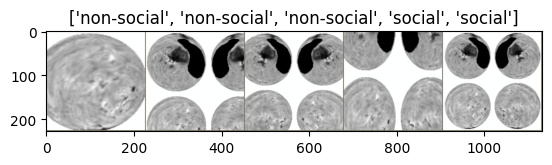

In [6]:
# Get a batch of training data
# The dataloaders dictionary contains data loaders for 'train' and 'val' subsets
# 'iter' creates an iterator from the data loader, 'next' retrieves the next batch
inputs, classes = next(iter(dataloaders['train']))

# Create a grid from the batch of images
# This creates a grid of images for easy visualization
out = torchvision.utils.make_grid(inputs, scale_each = True)

# Display the grid of images using the previously defined 'imshow' function
# The 'imshow' function displays images and their titles
# Titles are derived from class names corresponding to the classes of the images
imshow(out, title=[class_names[x] for x in classes])

In [7]:
import time
import os
import torch

# Define a function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train a model using the provided data and settings.
    
    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - criterion: The loss function to be used for optimization.
    - optimizer: The optimization algorithm used for updating model parameters.
    - scheduler: A learning rate scheduler to adjust the learning rate during training.
    - num_epochs (int): The number of training epochs (default is 25).
    
    Returns:
    - model (nn.Module): The trained model.
    """
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Save the initial model parameters to use as the best model initially
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Loop through each epoch
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Loop through training and validation phases
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    # Track history if only in training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Update statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                # Calculate epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if the validation accuracy is improved
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # Calculate time elapsed and print results
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
# Define a function to visualize model predictions
def visualize_model(model, num_images=6):
    """
    Visualize the predictions made by a trained model.
    
    Parameters:
    - model (nn.Module): The trained neural network model.
    - num_images (int): The number of images to visualize (default is 6).
    """
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Loop through images in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])  # Display the image

                # Stop visualization after displaying the specified number of images
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Fine-tuning a ConvNet using ResNet34 architecture
# Load the ResNet34 model with weights pre-trained on ImageNet
model_ft = models.resnet34(pretrained=True)
# Get the number of features in the fully connected layer (before classification)
num_ftrs = model_ft.fc.in_features
# Replace the fully connected layer with a new one for binary classification
model_ft.fc = nn.Linear(num_ftrs, 2)  # Output size set to 2 for binary classification
model_ft = model_ft.to(device)  # Move the model to the specified device

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer to optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate the fine-tuned model using the defined function
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# ConvNet as a fixed feature extractor
# Load the ResNet34 model with weights pre-trained on ImageNet
model_conv = models.resnet34(pretrained=True)
# Set all parameters to not require gradients (effectively freezing them)
for param in model_conv.parameters():
    param.requires_grad = False
# Get the number of features in the fully connected layer (before classification)
num_ftrs = model_conv.fc.in_features
# Replace the fully connected layer with a new one for binary classification
model_conv.fc = nn.Linear(num_ftrs, 2)  # Output size set to 2 for binary classification
model_conv = model_conv.to(device)  # Move the model to the specified device

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer to optimize only the parameters of the final layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/srv/conda/envs/notebook/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7813 Acc: 0.3947
val Loss: 0.6943 Acc: 0.4167

Epoch 1/24
----------
train Loss: 0.7573 Acc: 0.4737
val Loss: 0.7547 Acc: 0.4167

Epoch 2/24
----------
train Loss: 0.8745 Acc: 0.3947
val Loss: 0.8565 Acc: 0.5833

Epoch 3/24
----------
train Loss: 0.7068 Acc: 0.6316
val Loss: 0.7139 Acc: 0.5833

Epoch 4/24
----------
train Loss: 0.9355 Acc: 0.4737
val Loss: 0.7212 Acc: 0.5833

Epoch 5/24
----------
train Loss: 0.8774 Acc: 0.5263
val Loss: 0.6851 Acc: 0.5833

Epoch 6/24
----------
train Loss: 0.8528 Acc: 0.4474
val Loss: 0.7435 Acc: 0.5833

Epoch 7/24
----------
train Loss: 0.8171 Acc: 0.4474
val Loss: 0.7501 Acc: 0.5833

Epoch 8/24
----------
train Loss: 0.7678 Acc: 0.6316
val Loss: 0.7408 Acc: 0.5833

Epoch 9/24
----------
train Loss: 0.6847 Acc: 0.5526
val Loss: 0.6883 Acc: 0.5833

Epoch 10/24
----------
train Loss: 0.7273 Acc: 0.4474
val Loss: 0.7393 Acc: 0.4167

Epoch 11/24
----------
train Loss: 0.8203 Acc: 0.4737
val Loss: 0.7237 Acc: 0.4167

Ep

In [10]:
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7385 Acc: 0.3947
val Loss: 0.7449 Acc: 0.5833

Epoch 1/24
----------
train Loss: 0.8138 Acc: 0.6053
val Loss: 0.6966 Acc: 0.4167

Epoch 2/24
----------
train Loss: 0.8537 Acc: 0.4211
val Loss: 0.9515 Acc: 0.5833

Epoch 3/24
----------
train Loss: 0.7985 Acc: 0.5526
val Loss: 0.6814 Acc: 0.5833

Epoch 4/24
----------
train Loss: 0.7455 Acc: 0.3947
val Loss: 0.7837 Acc: 0.5833

Epoch 5/24
----------
train Loss: 0.9026 Acc: 0.5263
val Loss: 0.7418 Acc: 0.5833

Epoch 6/24
----------
train Loss: 0.9456 Acc: 0.5526
val Loss: 0.6814 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.8095 Acc: 0.4474
val Loss: 0.6777 Acc: 0.5833

Epoch 8/24
----------
train Loss: 0.6690 Acc: 0.5263
val Loss: 0.7425 Acc: 0.5833

Epoch 9/24
----------
train Loss: 0.6463 Acc: 0.6579
val Loss: 0.8301 Acc: 0.5833

Epoch 10/24
----------
train Loss: 0.7081 Acc: 0.6316
val Loss: 0.8121 Acc: 0.5833

Epoch 11/24
----------
train Loss: 0.6994 Acc: 0.6053
val Loss: 0.7577 Acc: 0.5833

Ep